In [26]:
!nvidia-smi

Mon May 24 17:30:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    33W / 250W |   4235MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torchvision
import torchvision.transforms as transforms
import torchvision.utils
from torchvision import datasets

import torch
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import os
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import PIL.ImageOps

In [ ]:
!cp '/content/drive/MyDrive/vinay_docs/signet_dataset.zip' .
!unzip signet_dataset.zip

# data is not at the content
!ls


In [4]:
def imshow(img, text=None, save=False):
  npimg = img.numpy()
  plt.axis('off')

  if text:
    plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

def show_plot(iteration, loss):
  plt.plt(iteration, loss)
  plt.show()



In [5]:
train_dir = '/content/train'
train_csv = '/content/train_data.csv'
test_dir = '/content/test'
test_csv = '/content/test_data.csv'

In [27]:
class Config():
  # train_dir = '/content/train'
  # test_dir = '/content/test'
  train_batch_size = 128
  train_no_epoch = 20

# preprocessing and loading the dataset
class SiameseDataset():
  def __init__(self, train_csv, train_dir, transform=None):
    self.train_df = pd.read_csv(train_csv)
    self.train_df.columns = ['image1','image2','label']
    self.train_dir = train_dir
    self.transform = transform
  
  def __getitem__(self, index):
    img1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
    img2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

    img0 = Image.open(img1_path)
    img1 = Image.open(img2_path)
    img0 = img0.convert('L')
    img1 = img1.convert('L')

    if self.transform is not None:
      img0 = self.transform(img0)
      img1 = self.transform(img1)
    return img0, img1, torch.from_numpy(np.array([int(self.train_df.iat[index,2])], dtype=np.float32))

  def __len__(self):
    return len(self.train_df)


In [7]:
transform = transforms.Compose(
      [transforms.Resize((105,105)),
      transforms.ToTensor()]
     )

siamese_dataset = SiameseDataset(train_csv, train_dir, transform=transform)

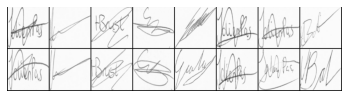

[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [8]:
vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [9]:
len(example_batch)

3

In [10]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()

    self.cnn1 = nn.Sequential(
        
        nn.Conv2d(1,96,kernel_size=11,stride=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5,alpha=0.0001, beta=0.75,k=2),
        nn.MaxPool2d(3, stride=2),

        nn.Conv2d(96,256,kernel_size=5,stride=1,padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5,alpha=0.0001, beta=0.75,k=2),
        nn.MaxPool2d(3, stride=2),

        nn.Dropout2d(p=0.3),

        nn.Conv2d(256,384,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(384,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(p=0.3),
    )

    self.fc1 = nn.Sequential(
        nn.Linear(30976,1024),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.5),

        nn.Linear(1024,128),
        nn.ReLU(inplace=True),
        nn.Linear(128,2)
    )

  def forward_once(self, x):
    output = self.cnn1(x)
    output = output.view(output.size()[0],-1)
    output = self.fc1(output)
    return output
  
  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1, output2

In [11]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=2.0):
    super(ContrastiveLoss, self).__init__()
    self.margin=margin
  
  def forward(self, output1, output2, label):
    euc_dist = F.pairwise_distance(output1, output2)
    loss_contrastive = torch.mean((1-label)*torch.pow(euc_dist,2) + 
                                  (label)*torch.pow(torch.clamp(self.margin - euc_dist, min=0.0), 2))
    return loss_contrastive


In [28]:
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              num_workers=8,
                              batch_size=Config.train_batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [29]:
if torch.cuda.is_available():
  print('Yes')
  device = 'cuda'
else:
  print('No')
  device = 'cpu'


Yes


In [30]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [31]:
# from tqdm import tqdm|
import tqdm.notebook as tq

In [32]:
def train():
  counter = []
  loss_history = []
  iteration_number = 0

  for epoch in range(0, 1):
    for i, data in tq.tqdm(enumerate(train_dataloader, 0)):
      img0, img1, label = data
      img0, img1, label = img0.to(device), img1.to(device), label.to(device) 
      optimizer.zero_grad()
      op1, op2 = net(img0, img1)
      loss_contrastive = criterion(op1, op2, label)
      loss_contrastive.backward()
      optimizer.step()
      if i%50 ==0:
        print(f'Epoch number {epoch}\n Current loss {loss_contrastive.item()}')
        iteration_number +=10
        counter.append(iteration_number)
        loss_history.append(loss_contrastive.item())
    return net

In [ ]:
!pip install wandb
import wandb
wandb.init()

In [35]:
for epoch in range(0, Config.train_no_epoch):
  model = train()
  torch.save(model.state_dict(),'model.pt')
  print(f'Model Saved {epoch}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch number 0
 Current loss 1.428741216659546
Epoch number 0
 Current loss 1.21197509765625
Epoch number 0
 Current loss 1.2446856498718262
Epoch number 0
 Current loss 1.1457369327545166

Model Saved 0


Epoch number 0
 Current loss 1.1110155582427979
Epoch number 0
 Current loss 1.1742825508117676
Epoch number 0
 Current loss 1.1655890941619873
Epoch number 0
 Current loss 1.1303813457489014

Model Saved 1


Epoch number 0
 Current loss 1.278151273727417
Epoch number 0
 Current loss 1.0311437845230103
Epoch number 0
 Current loss 1.301758050918579
Epoch number 0
 Current loss 1.2002570629119873

Model Saved 2


Epoch number 0
 Current loss 1.145457148551941
Epoch number 0
 Current loss 1.1625258922576904
Epoch number 0
 Current loss 1.2171440124511719
Epoch number 0
 Current loss 1.0698212385177612

Model Saved 3


Epoch number 0
 Current loss 1.2418062686920166
Epoch number 0
 Current loss 1.094127893447876
Epoch number 0
 Current loss 1.145491123199463
Epoch number 0
 Current loss 1.2007567882537842

Model Saved 4


Epoch number 0
 Current loss 1.1217706203460693
Epoch number 0
 Current loss 1.2524511814117432
Epoch number 0
 Current loss 1.1430732011795044
Epoch number 0
 Current loss 1.1585079431533813

Model Saved 5


Epoch number 0
 Current loss 1.088454008102417
Epoch number 0
 Current loss 1.1864798069000244
Epoch number 0
 Current loss 1.1242501735687256
Epoch number 0
 Current loss 1.165074110031128

Model Saved 6


Epoch number 0
 Current loss 1.2154548168182373
Epoch number 0
 Current loss 1.2216596603393555
Epoch number 0
 Current loss 1.1263117790222168
Epoch number 0
 Current loss 1.12698233127594

Model Saved 7


Epoch number 0
 Current loss 1.206039309501648
Epoch number 0
 Current loss 1.170785903930664
Epoch number 0
 Current loss 1.1825984716415405
Epoch number 0
 Current loss 1.1316239833831787

Model Saved 8


Epoch number 0
 Current loss 1.2417880296707153
Epoch number 0
 Current loss 1.1517049074172974
Epoch number 0
 Current loss 1.0970526933670044
Epoch number 0
 Current loss 1.1142377853393555

Model Saved 9


Epoch number 0
 Current loss 1.1192848682403564
Epoch number 0
 Current loss 1.3214868307113647
Epoch number 0
 Current loss 1.2199678421020508
Epoch number 0
 Current loss 1.0974253416061401

Model Saved 10


Epoch number 0
 Current loss 1.196431279182434
Epoch number 0
 Current loss 1.2610886096954346
Epoch number 0
 Current loss 1.2100809812545776
Epoch number 0
 Current loss 1.2270668745040894

Model Saved 11


Epoch number 0
 Current loss 1.1396503448486328
Epoch number 0
 Current loss 1.3113590478897095
Epoch number 0
 Current loss 1.1677799224853516
Epoch number 0
 Current loss 1.1815569400787354

Model Saved 12


Epoch number 0
 Current loss 1.136050820350647
Epoch number 0
 Current loss 1.117093563079834
Epoch number 0
 Current loss 1.1757206916809082
Epoch number 0
 Current loss 1.1509289741516113

Model Saved 13


Epoch number 0
 Current loss 1.1273441314697266
Epoch number 0
 Current loss 1.228271722793579
Epoch number 0
 Current loss 1.1596230268478394
Epoch number 0
 Current loss 1.1666691303253174

Model Saved 14


Epoch number 0
 Current loss 1.1410000324249268
Epoch number 0
 Current loss 1.1519920825958252
Epoch number 0
 Current loss 1.22589910030365
Epoch number 0
 Current loss 1.1805375814437866

Model Saved 15


Epoch number 0
 Current loss 1.1602914333343506
Epoch number 0
 Current loss 1.1244220733642578
Epoch number 0
 Current loss 1.0283503532409668
Epoch number 0
 Current loss 1.161110758781433

Model Saved 16


Epoch number 0
 Current loss 1.1667057275772095
Epoch number 0
 Current loss 1.1764001846313477
Epoch number 0
 Current loss 1.126199722290039
Epoch number 0
 Current loss 1.1049063205718994

Model Saved 17


Epoch number 0
 Current loss 1.1810380220413208
Epoch number 0
 Current loss 1.3071873188018799
Epoch number 0
 Current loss 1.1831144094467163
Epoch number 0
 Current loss 1.1090009212493896

Model Saved 18


Epoch number 0
 Current loss 1.171102523803711
Epoch number 0
 Current loss 1.170253038406372
Epoch number 0
 Current loss 1.2043230533599854
Epoch number 0
 Current loss 1.168148398399353

Model Saved 19


In [36]:
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [37]:
transform = transforms.Compose(
      [transforms.Resize((105,105)),
      transforms.ToTensor()]
     )

test_dataset = SiameseDataset(test_csv, test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

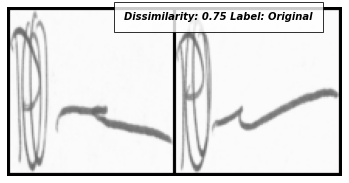

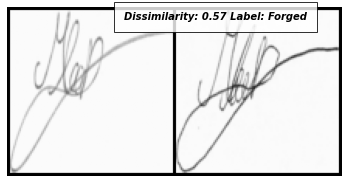

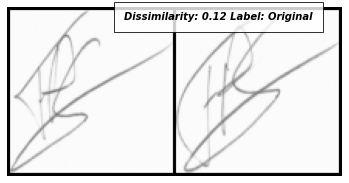

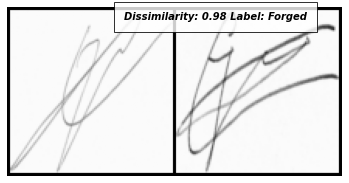

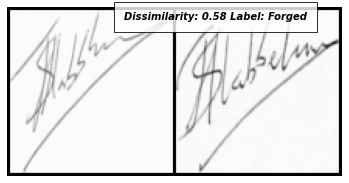

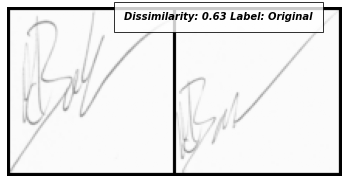

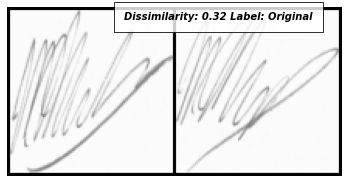

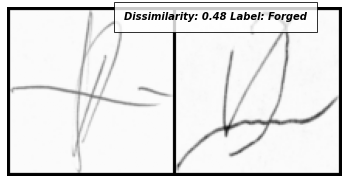

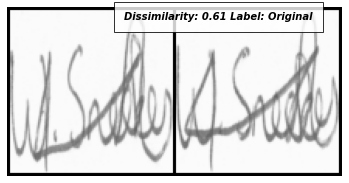

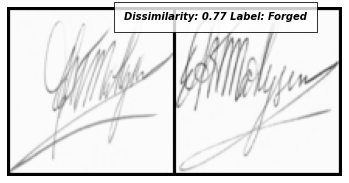

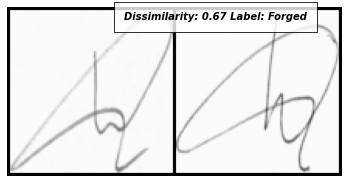

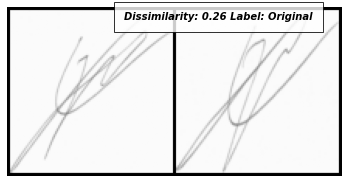

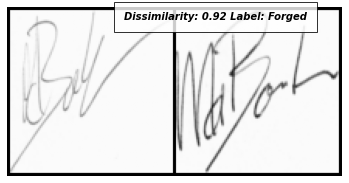

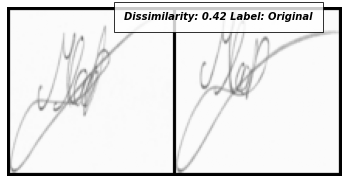

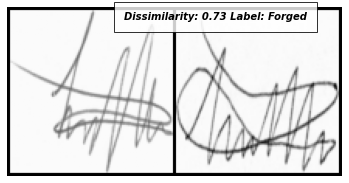

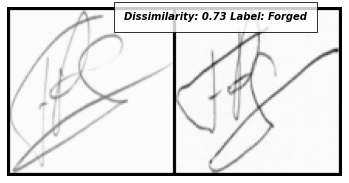

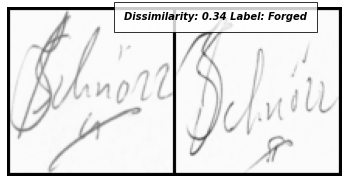

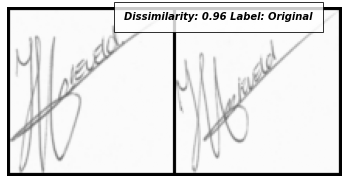

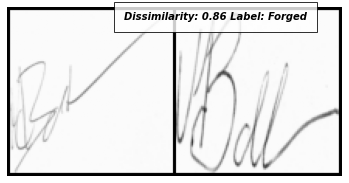

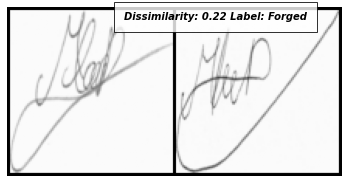

In [38]:
counter = 0 
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])

for i, data in enumerate(test_dataloader, 0):
  x0, x1, label = data
  concatenated = torch.cat((x0, x1),0)
  op1, op2 = model(x0.to(device), x1.to(device))
  euc_dist = F.pairwise_distance(op1, op2)

  if label==list_0:
    label="Original"
  else:
    label="Forged"

  imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euc_dist.item():.2f} Label: {label}')
  counter+=1
  if counter==20:
    break

In [40]:
accuracy = 0
counter = 0
correct = 0
for i, data in enumerate(test_dataloader, 0):
  x0, x1, label = data
  op1, op2 = model(x0.to(device), x1.to(device))
  res = torch.abs(op1.to(device) - op2.to(device))
  label = label[0].tolist()
  label = int(label[0])
  result = torch.max(res, 1)[1][0][0].data[0].tolist()
  if label == result:
    correct+=1
  counter+=1

accuracy=(correct/len(test_dataloader)) *100
print(f"Accuracy {accuracy}")

IndexError: ignored

In [41]:
net

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=30976, out_features=1024, bias=True)
    (1): Re

In [43]:
for i in net.parameters():
  print(i)

Parameter containing:
tensor([[[[-8.8486e-04, -9.1268e-04, -8.7926e-04,  ..., -8.6153e-04,
           -8.8660e-04, -8.9328e-04],
          [-8.9017e-04, -9.1720e-04, -8.8107e-04,  ..., -8.7099e-04,
           -8.9783e-04, -8.9885e-04],
          [-8.9135e-04, -9.1691e-04, -8.7860e-04,  ..., -8.7864e-04,
           -9.0377e-04, -8.9817e-04],
          ...,
          [-8.9272e-04, -9.1192e-04, -8.7313e-04,  ..., -8.8603e-04,
           -9.1146e-04, -8.9212e-04],
          [-8.9370e-04, -9.0693e-04, -8.6930e-04,  ..., -8.8579e-04,
           -9.0983e-04, -8.8969e-04],
          [-8.8888e-04, -8.9565e-04, -8.6202e-04,  ..., -8.8343e-04,
           -9.0508e-04, -8.8202e-04]]],


        [[[-8.5693e-03, -8.8144e-03, -9.4118e-03,  ..., -1.0596e-02,
           -9.8437e-03, -9.6547e-03],
          [-8.6459e-03, -8.8006e-03, -9.4592e-03,  ..., -1.0088e-02,
           -9.6264e-03, -9.6465e-03],
          [-8.8381e-03, -9.0120e-03, -9.6528e-03,  ..., -1.0093e-02,
           -9.8277e-03, -9.8892e-0